In [1]:
import sys
import random

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pingouin as pg
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import wilcoxon


In [2]:
truth = pd.read_csv("groundtruth.csv", sep=',', index_col=0)
truth

,Inh L1 LAMP5 NMBR,Inh L1 PVALB SST ASIC4,Inh L1 SST DEFB108B,Exc L2 LINC00507 ATP7B,Inh L2 PVALB FRZB,Exc L2 LINC00507 GLRA3,Inh L2 VIP SLC6A16,Exc L2-3 RORB CCDC68,Exc L2-3 RORB RTKN2,Exc L3 RORB OTOGL,...,Inh L2-5 PVALB HHIPL1,Inh L1 LAMP5 PVRL2,Inh L1-2 VIP PTGER3,Inh L1-5 VIP PHLDB3,Inh L1 VIP KLHDC8B,Exc L5-6 FEZF2 CFTR,Inh L1-3 VIP FNDC1,Exc L3-5 FEZF2 LINC01107,Inh L1-6 SST NPY,Inh L3-6 PAX6 LINC01497
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
celltype_counts = truth.sum(axis=0)
celltype_counts = celltype_counts.sort_values(ascending=False)
celltype_counts
major_celltypes = celltype_counts[celltype_counts >= 350].index
major_celltypes

Index(['Exc L2 LINC00507 GLRA3', 'Exc L5-6 FEZF2 C9orf135-AS1',
       'Oligo L2-6 OPALIN FTH1P3', 'Exc L6 THEMIS LINC00343',
       'Exc L3 LAMP5 CARM1P1', 'Exc L3-5 RORB LNX2'],
      dtype='object')

---
## Figure 1

In [4]:
def plot_pcc_ax(ax, true, pred, dot_color='limegreen', dot_size=20, title=""):
    pcc, _ = pearsonr(true, pred)

    ax.scatter(true, pred, alpha=0.5, s=dot_size, color=dot_color)

    # lims = [0, max(max(true), max(pred)) * 1.05]
    lims = [0, 1]
    ax.plot(lims, lims, linestyle='--', color='gray')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.text(lims[0] + 0.05, lims[1]*0.7, f"PCC = {pcc:.2f}", fontsize=10)
    ax.set_xlabel("True", fontsize=12)
    ax.set_ylabel("Predicted", fontsize=12)
    ax.set_title(title, fontsize=13)
    ax.grid(True)


In [5]:
tangram_all_refer = pd.read_csv("Tangram_result.txt", sep=',', index_col=0)
true_full_tangram = []
pred_full_tangram = []
for i in range(len(truth)):
    index = np.where(truth.iloc[i, :] != 0)[0]
    truth_type = truth.iloc[i, index]
    for j in truth_type.index:
        try:
            pred_full_tangram.append(tangram_all_refer.loc[i, j])
            true_full_tangram.append(truth_type[j] / sum(truth_type))
        except KeyError:
            continue
print(len(true_full_tangram), len(pred_full_tangram))
true_top6_tangram = []
pred_top6_tangram = []
for i in range(len(truth)):
    index = np.where(truth.iloc[i, :] != 0)[0]
    truth_type = truth.iloc[i, index]
    for j in truth_type.index:
        if j in major_celltypes:
            try:
                pred_top6_tangram.append(tangram_all_refer.loc[i, j])
                true_top6_tangram.append(truth_type[j] / sum(truth_type))
            except KeyError:
                continue
print(len(true_top6_tangram), len(pred_top6_tangram))
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# plot_pcc_ax(ax[0], true_full_tangram, pred_full_tangram, dot_color='limegreen', dot_size=20, title="Tangram (All Cell Types)")
# plot_pcc_ax(ax[1], true_top6_tangram, pred_top6_tangram, dot_color='limegreen', dot_size=20, title="Tangram (Top 6 Cell Types)")
# plt.tight_layout()

3914 3914
1247 1247


In [6]:
card_all_refer = pd.read_csv("card_result.csv", sep=',').drop(columns=['Unnamed: 0'])
true_full_card = []
pred_full_card = []
for i in range(len(truth)):
    index = np.where(truth.iloc[i, :] != 0)[0]
    truth_type = truth.iloc[i, index]
    for j in truth_type.index:
        try:
            pred_full_card.append(card_all_refer.loc[i, j])
            true_full_card.append(truth_type[j] / sum(truth_type))
        except KeyError:
            continue
print(len(true_full_card), len(pred_full_card))
true_top6_card = []
pred_top6_card = []
for i in range(len(truth)):
    index = np.where(truth.iloc[i, :] != 0)[0]
    truth_type = truth.iloc[i, index]
    for j in truth_type.index:
        if j in major_celltypes:
            try:
                pred_top6_card.append(card_all_refer.loc[i, j])
                true_top6_card.append(truth_type[j] / sum(truth_type))
            except KeyError:
                continue
print(len(true_top6_card), len(pred_top6_card))
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# plot_pcc_ax(ax[0], true_full_card, pred_full_card, dot_color='limegreen', dot_size=20, title="Card (All Cell Types)")
# plot_pcc_ax(ax[1], true_top6_card, pred_top6_card, dot_color='limegreen', dot_size=20, title="Card (Top 6 Cell Types)")
# plt.tight_layout()

3918 3918
1247 1247


In [7]:
c2l_all_refer = pd.read_csv('cell2loc_result.csv', sep=',').drop(columns=['Unnamed: 0'])
c2l_all_refer.columns = c2l_all_refer.columns.astype(str).str.split('_').str[-1]
true_full_c2l = []
pred_full_c2l = []
for i in range(len(truth)):
    index = np.where(truth.iloc[i, :] != 0)[0]
    truth_type = truth.iloc[i, index]
    for j in truth_type.index:
        try:
            pred_full_c2l.append(c2l_all_refer.loc[i, j] / sum(c2l_all_refer.loc[i, :]))
            true_full_c2l.append(truth_type[j] / sum(truth_type))
        except KeyError:
            continue
print(len(true_full_c2l), len(pred_full_c2l))
true_top6_c2l = []
pred_top6_c2l = []
for i in range(len(truth)):
    index = np.where(truth.iloc[i, :] != 0)[0]
    truth_type = truth.iloc[i, index]
    for j in truth_type.index:
        if j in major_celltypes:
            try:
                pred_top6_c2l.append(c2l_all_refer.loc[i, j] / sum(c2l_all_refer.loc[i, :]))
                true_top6_c2l.append(truth_type[j] / sum(truth_type))
            except KeyError:
                continue
print(len(true_top6_c2l), len(pred_top6_c2l))
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# plot_pcc_ax(ax[0], true_full_c2l, pred_full_c2l, dot_color='limegreen', dot_size=20, title="Cell2Loc (All Cell Types)")
# plot_pcc_ax(ax[1], true_top6_c2l, pred_top6_c2l, dot_color='limegreen', dot_size=20, title="Cell2Loc (Top 6 Cell Types)")
# plt.tight_layout()

3914 3914
1247 1247


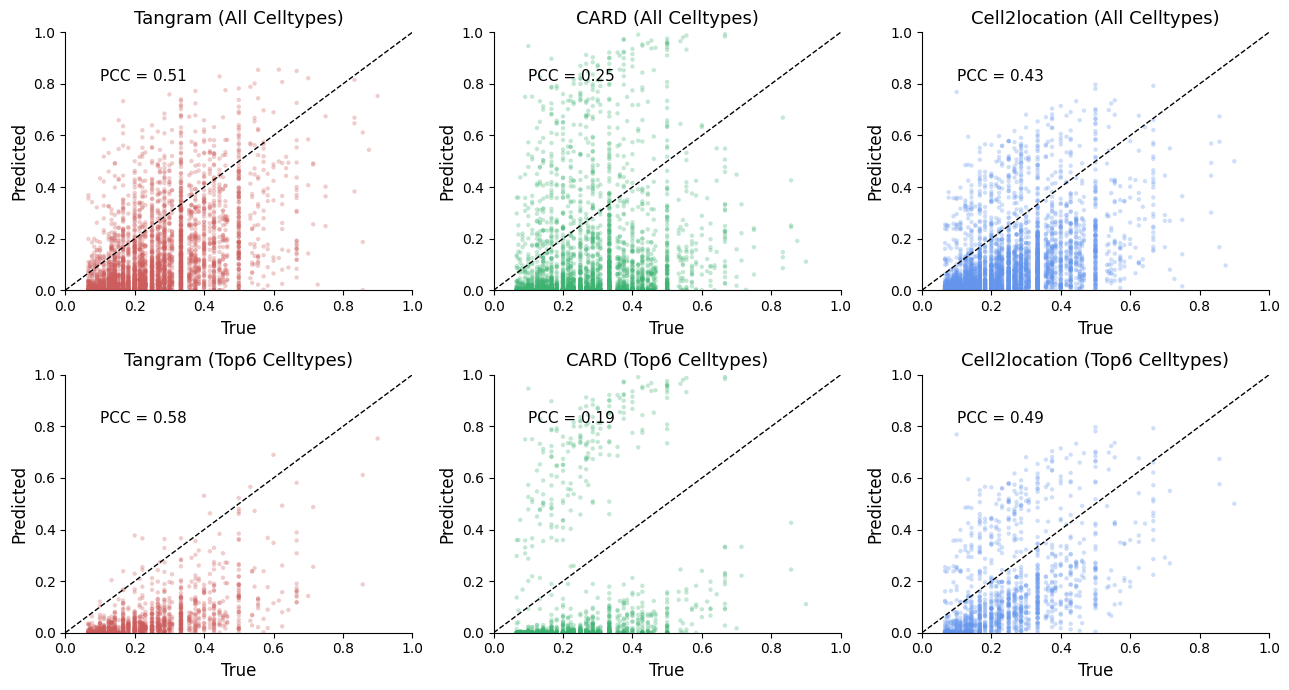

In [8]:
def plot_pcc_ax(ax, true, pred, dot_color='C0', dot_size=10, title=""):
    pcc, _ = pearsonr(true, pred)

    ax.scatter(true, pred, alpha=0.3, s=dot_size, color=dot_color, edgecolors='none')
    lims = [0, 1]
    ax.plot(lims, lims, linestyle='--', color='black', linewidth=1)

    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.text(0.1, 0.8, f"PCC = {pcc:.2f}", fontsize=11, ha='left', va='bottom')

    ax.set_xlabel("True", fontsize=12)
    ax.set_ylabel("Predicted", fontsize=12)
    ax.set_title(title, fontsize=13)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)

    ax.tick_params(axis='both', labelsize=10)

# 主图绘制（2×3 子图）
fig, axs = plt.subplots(2, 3, figsize=(13, 7))

plot_pcc_ax(axs[0, 0], true_full_tangram, pred_full_tangram, title="Tangram (All Celltypes)", dot_color='indianred')
plot_pcc_ax(axs[0, 1], true_full_card, pred_full_card, title="CARD (All Celltypes)", dot_color='mediumseagreen')
plot_pcc_ax(axs[0, 2], true_full_c2l, pred_full_c2l, title="Cell2location (All Celltypes)", dot_color='cornflowerblue')

plot_pcc_ax(axs[1, 0], true_top6_tangram, pred_top6_tangram, title="Tangram (Top6 Celltypes)", dot_color='indianred')
plot_pcc_ax(axs[1, 1], true_top6_card, pred_top6_card, title="CARD (Top6 Celltypes)", dot_color='mediumseagreen')
plot_pcc_ax(axs[1, 2], true_top6_c2l, pred_top6_c2l, title="Cell2location (Top6 Celltypes)", dot_color='cornflowerblue')

plt.tight_layout()
plt.savefig("six_pcc_refined.pdf", bbox_inches='tight')
plt.show()


---

## Figure 2

In [9]:
tangram_sub_refer = pd.read_csv("Tangram_result_sub.txt", sep=',', index_col=0)
true_sub_tangram = []
pred_sub_tangram = []
for i in range(len(truth)):
    index = np.where(truth.iloc[i, :] != 0)[0]
    truth_type = truth.iloc[i, index]
    for j in truth_type.index:
        try:
            pred_sub_tangram.append(tangram_sub_refer.loc[i, j])
            true_sub_tangram.append(truth_type[j] / sum(truth_type))
        except KeyError:
            continue
print(len(true_sub_tangram), len(pred_sub_tangram))

truth_copy = truth.copy().loc[:, tangram_all_refer.columns]
pcc_spot_full_tangram = []
pcc_spot_sub_tangram = []
for i in range(len(truth)):
    pcc_spot_full_tangram.append(
        pg.corr(
            x=truth_copy.iloc[i, :].values,
            y=tangram_all_refer.iloc[i, :].values,
            method="pearson",
        )["r"].values[0]
    )
    pcc_spot_sub_tangram.append(
        pg.corr(
            x=truth_copy.iloc[i, :].values,
            y=tangram_sub_refer.iloc[i, :].values,
            method="pearson",
        )["r"].values[0]
    )

3914 3914


In [10]:
card_sub_refer = pd.read_csv("card_sub10.csv", sep=',').drop(columns=['Unnamed: 0'])
true_sub_card = []
pred_sub_card = []
for i in range(len(truth)):
    index = np.where(truth.iloc[i, :] != 0)[0]
    truth_type = truth.iloc[i, index]
    for j in truth_type.index:
        try:
            pred_sub_card.append(card_sub_refer.loc[i, j])
            true_sub_card.append(truth_type[j] / sum(truth_type))
        except KeyError:
            continue
print(len(true_sub_card), len(pred_sub_card))

truth_copy = truth.copy().loc[:, card_all_refer.columns]
pcc_spot_full_card = []
pcc_spot_sub_card = []
for i in range(len(truth)):
    pcc_spot_full_card.append(
        pg.corr(
            x=truth_copy.iloc[i, :].values,
            y=card_all_refer.iloc[i, :].values,
            method="pearson",
        )["r"].values[0]
    )
    pcc_spot_sub_card.append(
        pg.corr(
            x=truth_copy.iloc[i, :].values,
            y=card_sub_refer.iloc[i, :].values,
            method="pearson",
        )["r"].values[0]
    )


3918 3918


In [11]:
c2l_sub_refer = pd.read_csv('Cell2location_result_sub.txt', sep=',').drop(columns=['Unnamed: 0'])
c2l_sub_refer.columns = c2l_sub_refer.columns.astype(str).str.split('_').str[-1]
true_sub_c2l = []
pred_sub_c2l = []
for i in range(len(truth)):
    index = np.where(truth.iloc[i, :] != 0)[0]
    truth_type = truth.iloc[i, index]
    for j in truth_type.index:
        try:
            pred_sub_c2l.append(c2l_sub_refer.loc[i, j] / sum(c2l_sub_refer.loc[i, :]))
            true_sub_c2l.append(truth_type[j] / sum(truth_type))
        except KeyError:
            continue
print(len(true_sub_c2l), len(pred_sub_c2l))

truth_copy = truth.copy().loc[:, c2l_all_refer.columns]
pcc_spot_full_c2l = []
pcc_spot_sub_c2l = []
for i in range(len(truth)):
    pcc_spot_full_c2l.append(
        pg.corr(
            x=truth_copy.iloc[i, :].values,
            y=c2l_all_refer.iloc[i, :].values,
            method="pearson",
        )["r"].values[0]
    )
    pcc_spot_sub_c2l.append(
        pg.corr(
            x=truth_copy.iloc[i, :].values,
            y=c2l_sub_refer.iloc[i, :].values,
            method="pearson",
        )["r"].values[0]
    )

3914 3914


In [12]:
pcc_spot_full_tangram_majortype = []
pcc_spot_sub_tangram_majortype = []

for i in range(len(truth)):
    pcc_spot_full_tangram_majortype.append(
        pg.corr(
            x=truth_copy.loc[i, major_celltypes].values,
            y=c2l_all_refer.loc[i, major_celltypes].values,
            method="pearson",
        )["r"].values[0]
    )
    pcc_spot_sub_tangram_majortype.append(
        pg.corr(
            x=truth_copy.loc[i, major_celltypes].values,
            y=c2l_sub_refer.loc[i, major_celltypes].values,
            method="pearson",
        )["r"].values[0]
    )

pcc_spot_full_card_majortype = []
pcc_spot_sub_card_majortype = []
for i in range(len(truth)):
    pcc_spot_full_card_majortype.append(
        pg.corr(
            x=truth_copy.loc[i, major_celltypes].values,
            y=card_all_refer.loc[i, major_celltypes].values / sum(card_all_refer.loc[i, :]),
            method="pearson",
        )["r"].values[0]
    )
    pcc_spot_sub_card_majortype.append(
        pg.corr(
            x=truth_copy.loc[i, major_celltypes].values,
            y=card_sub_refer.loc[i, major_celltypes].values / sum(card_sub_refer.loc[i, :]),
            method="pearson",
        )["r"].values[0]
    )

pcc_spot_full_c2l_majortype = []
pcc_spot_sub_c2l_majortype = []
for i in range(len(truth)):
    pcc_spot_full_c2l_majortype.append(
        pg.corr(
            x=truth_copy.loc[i, major_celltypes].values,
            y=c2l_all_refer.loc[i, major_celltypes].values / sum(c2l_all_refer.loc[i, :]),
            method="pearson",
        )["r"].values[0]
    )
    pcc_spot_sub_c2l_majortype.append(
        pg.corr(
            x=truth_copy.loc[i, major_celltypes].values,
            y=c2l_sub_refer.loc[i, major_celltypes].values / sum(c2l_sub_refer.loc[i, :]),
            method="pearson",
        )["r"].values[0]
    )
print(len(pcc_spot_full_tangram_majortype), len(pcc_spot_sub_tangram_majortype))
print(len(pcc_spot_full_card_majortype), len(pcc_spot_sub_card_majortype))
print(len(pcc_spot_full_c2l_majortype), len(pcc_spot_sub_c2l_majortype))

/Users/bianco/Softwares/miniconda3/envs/cmml3_pip/lib/python3.11/site-packages/pingouin/correlation.py:604: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, pval = pearsonr(x, y)
/Users/bianco/Softwares/miniconda3/envs/cmml3_pip/lib/python3.11/site-packages/pingouin/correlation.py:604: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, pval = pearsonr(x, y)
/Users/bianco/Softwares/miniconda3/envs/cmml3_pip/lib/python3.11/site-packages/pingouin/correlation.py:604: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, pval = pearsonr(x, y)
/Users/bianco/Softwares/miniconda3/envs/cmml3_pip/lib/python3.11/site-packages/pingouin/correlation.py:604: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, pval = pearsonr(x, y)
/Users/bianco/Softwares/miniconda3/envs/cmml3_pip/lib/python3.11/site-packages/pingo

1000 1000
1000 1000
1000 1000


/Users/bianco/Softwares/miniconda3/envs/cmml3_pip/lib/python3.11/site-packages/pingouin/correlation.py:604: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, pval = pearsonr(x, y)
/Users/bianco/Softwares/miniconda3/envs/cmml3_pip/lib/python3.11/site-packages/pingouin/correlation.py:604: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, pval = pearsonr(x, y)
/Users/bianco/Softwares/miniconda3/envs/cmml3_pip/lib/python3.11/site-packages/pingouin/correlation.py:604: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, pval = pearsonr(x, y)
/Users/bianco/Softwares/miniconda3/envs/cmml3_pip/lib/python3.11/site-packages/pingouin/correlation.py:604: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, pval = pearsonr(x, y)
/Users/bianco/Softwares/miniconda3/envs/cmml3_pip/lib/python3.11/site-packages/pingo

In [13]:
def plot_pcc_ax(ax, true, pred, dot_color='C0', dot_size=10, title="", label="PCC"):
    from scipy.stats import pearsonr
    pcc, _ = pearsonr(true, pred)

    ax.scatter(true, pred, alpha=0.3, s=dot_size, color=dot_color, edgecolors='none')
    lims = [0, 1]
    ax.plot(lims, lims, linestyle='--', color='black', linewidth=1)
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.text(0.1, 0.8, f"{label} = {pcc:.2f}", fontsize=10)
    ax.set_xlabel("True", fontsize=12)
    ax.set_ylabel("Predicted", fontsize=12)
    ax.set_title(title, fontsize=13)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=9)


def plot_rs_ax(ax, pcc_gt, pcc_ds, title=""):
    ax.scatter(pcc_gt, pcc_ds, s=8, alpha=0.4, color='gray')
    ax.plot([-0.05, 1], [-0.05, 1], '--', color='black', linewidth=1)
    rect = patches.Rectangle((0.5, 0.5), 0.5, 0.5,
                             linewidth=1,
                             edgecolor='red',
                             linestyle='--',
                             facecolor='none')
    ax.add_patch(rect)
    ax.set_xlim(-0.05, 1)
    ax.set_ylim(-0.05, 1)

    red_x = []
    red_y = []
    for x, y in zip(pcc_gt, pcc_ds):
        if x > 0.5 and y > 0.5:
            red_x.append(x)
            red_y.append(y)
    ax.scatter(red_x, red_y, s=8, color='red', alpha=0.6)

    rs = len(red_x) / len(pcc_gt)
    ax.text(0.1, 0.8, f"RS = {rs:.2f}", fontsize=10)

    ax.set_xlabel("PCC (full reference)", fontsize=12)
    ax.set_ylabel("PCC (subsampled reference)", fontsize=12)
    ax.set_title(title, fontsize=13)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    ax.tick_params(axis='both', labelsize=9)

# fig, axs = plt.subplots(1, 3, figsize=(16, 4))
# plot_rs_ax(axs[0], pcc_spot_full_tangram_majortype, pcc_spot_sub_tangram_majortype, title="Tangram RS")
# plot_rs_ax(axs[1], pcc_spot_full_card_majortype, pcc_spot_sub_card_majortype, title="CARD RS")
# plot_rs_ax(axs[2], pcc_spot_full_c2l_majortype, pcc_spot_sub_c2l_majortype, title="Cell2location RS")

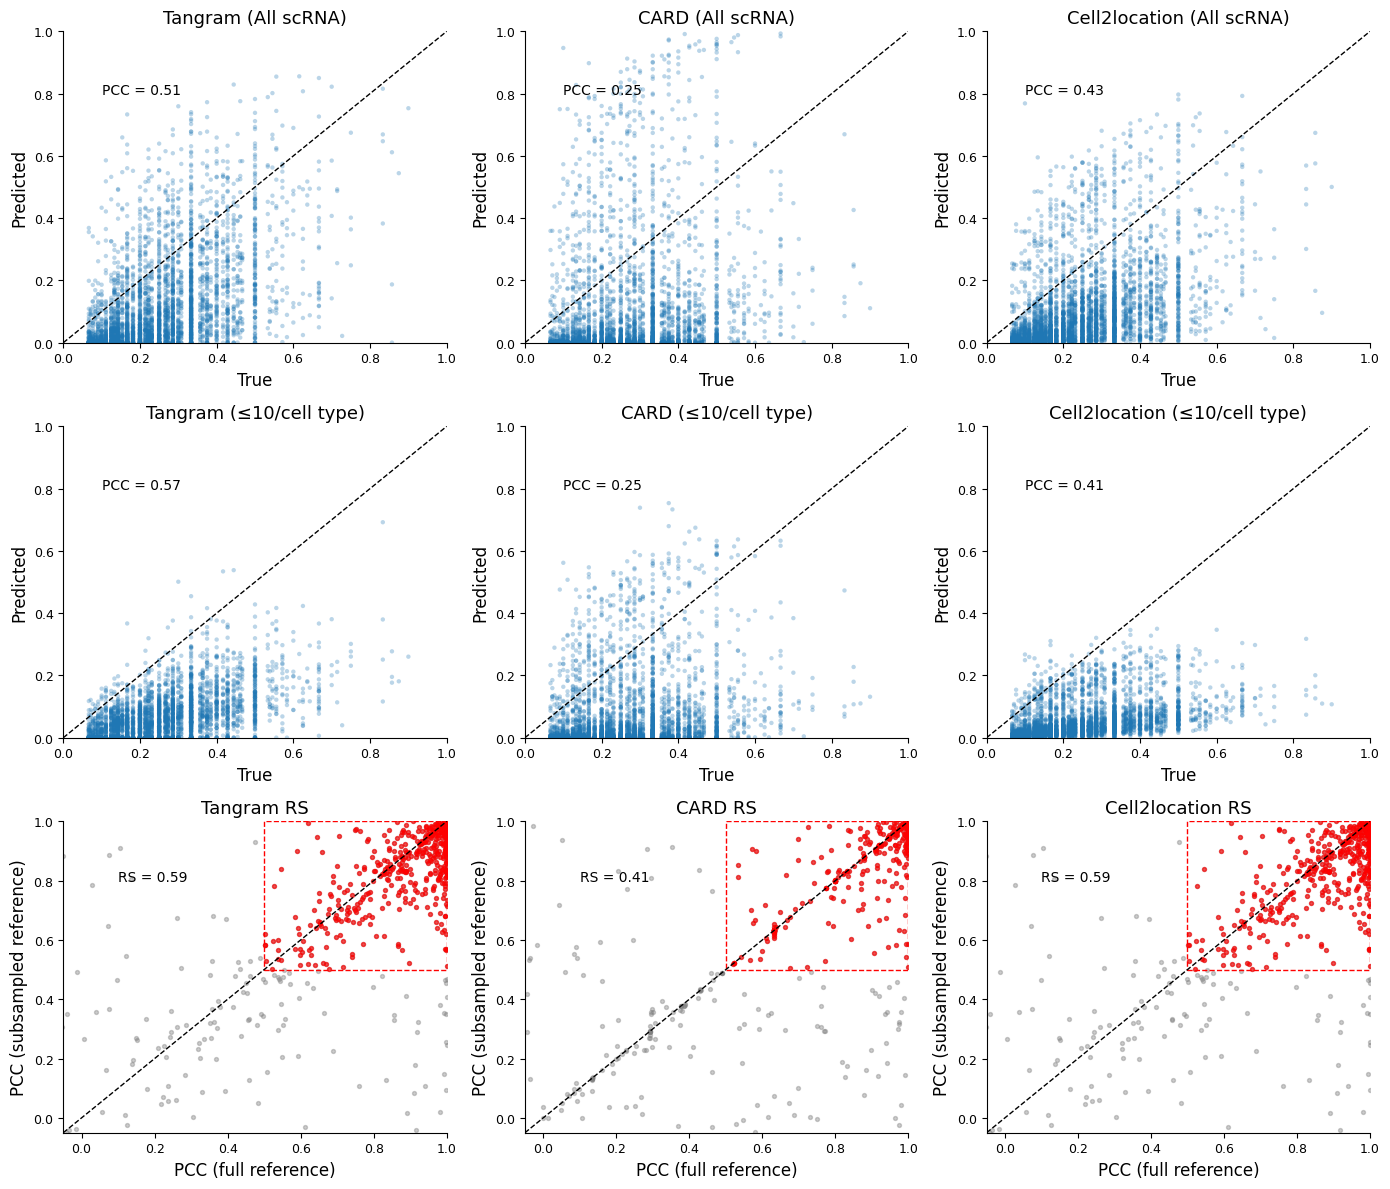

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(14, 12))

plot_pcc_ax(axs[0, 0], true_full_tangram, pred_full_tangram, title="Tangram (All scRNA)")
plot_pcc_ax(axs[0, 1], true_full_card, pred_full_card, title="CARD (All scRNA)")
plot_pcc_ax(axs[0, 2], true_full_c2l, pred_full_c2l, title="Cell2location (All scRNA)")

plot_pcc_ax(axs[1, 0], true_sub_tangram, pred_sub_tangram, title="Tangram (≤10/cell type)")
plot_pcc_ax(axs[1, 1], true_sub_card, pred_sub_card, title="CARD (≤10/cell type)")
plot_pcc_ax(axs[1, 2], true_sub_c2l, pred_sub_c2l, title="Cell2location (≤10/cell type)")

plot_rs_ax(axs[2, 0], pcc_spot_full_tangram_majortype, pcc_spot_sub_tangram_majortype, title="Tangram RS")
plot_rs_ax(axs[2, 1], pcc_spot_full_card_majortype, pcc_spot_sub_card_majortype, title="CARD RS")
plot_rs_ax(axs[2, 2], pcc_spot_full_c2l_majortype, pcc_spot_sub_c2l_majortype, title="Cell2location RS")

plt.tight_layout()
plt.savefig("pcc_rs_3x3.pdf", bbox_inches='tight')
plt.show()

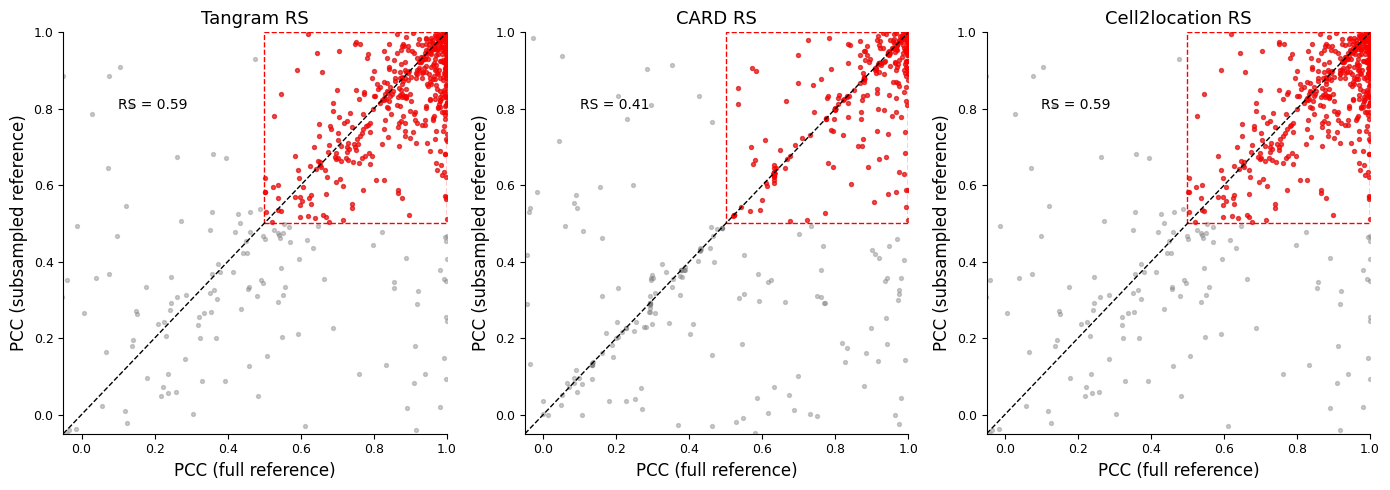

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

plot_rs_ax(axs[0], pcc_spot_full_tangram_majortype, pcc_spot_sub_tangram_majortype, title="Tangram RS")
plot_rs_ax(axs[1], pcc_spot_full_card_majortype, pcc_spot_sub_card_majortype, title="CARD RS")
plot_rs_ax(axs[2], pcc_spot_full_c2l_majortype, pcc_spot_sub_c2l_majortype, title="Cell2location RS")

plt.tight_layout()
plt.savefig("pcc_rs_1x3.pdf", dpi=600, bbox_inches='tight')
plt.show()

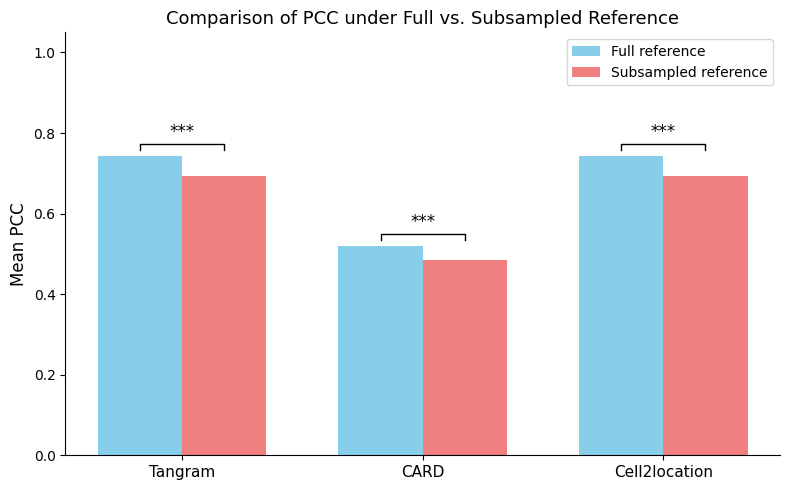

In [17]:
pcc_spot_full_tangram_majortype = np.array(pcc_spot_full_tangram_majortype)
pcc_spot_sub_tangram_majortype = np.array(pcc_spot_sub_tangram_majortype)
pcc_spot_full_card_majortype = np.array(pcc_spot_full_card_majortype)
pcc_spot_sub_card_majortype = np.array(pcc_spot_sub_card_majortype)
pcc_spot_full_c2l_majortype = np.array(pcc_spot_full_c2l_majortype)
pcc_spot_sub_c2l_majortype = np.array(pcc_spot_sub_c2l_majortype)
pcc_spot_full_tangram_majortype = pcc_spot_full_tangram_majortype[~np.isnan(pcc_spot_full_tangram_majortype)]
pcc_spot_sub_tangram_majortype = pcc_spot_sub_tangram_majortype[~np.isnan(pcc_spot_sub_tangram_majortype)]
pcc_spot_full_card_majortype = pcc_spot_full_card_majortype[~np.isnan(pcc_spot_full_card_majortype)]
pcc_spot_sub_card_majortype = pcc_spot_sub_card_majortype[~np.isnan(pcc_spot_sub_card_majortype)]
pcc_spot_full_c2l_majortype = pcc_spot_full_c2l_majortype[~np.isnan(pcc_spot_full_c2l_majortype)]
pcc_spot_sub_c2l_majortype = pcc_spot_sub_c2l_majortype[~np.isnan(pcc_spot_sub_c2l_majortype)]

mean_pcc_full = [
    np.mean(pcc_spot_full_tangram_majortype),
    np.mean(pcc_spot_full_card_majortype),
    np.mean(pcc_spot_full_c2l_majortype)
]
mean_pcc_sub = [
    np.mean(pcc_spot_sub_tangram_majortype),
    np.mean(pcc_spot_sub_card_majortype),
    np.mean(pcc_spot_sub_c2l_majortype)
]

pvals = [
    wilcoxon(pcc_spot_full_tangram_majortype, pcc_spot_sub_tangram_majortype).pvalue,
    wilcoxon(pcc_spot_full_card_majortype, pcc_spot_sub_card_majortype).pvalue,
    wilcoxon(pcc_spot_full_c2l_majortype, pcc_spot_sub_c2l_majortype).pvalue
]

labels = ['Tangram', 'CARD', 'Cell2location']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))

bars1 = ax.bar(x - width/2, mean_pcc_full, width, label='Full reference', color='skyblue')
bars2 = ax.bar(x + width/2, mean_pcc_sub, width, label='Subsampled reference', color='lightcoral')

for i in range(len(pvals)):
    y_max = max(mean_pcc_full[i], mean_pcc_sub[i])
    h = 0.015
    x1 = x[i] - width / 2
    x2 = x[i] + width / 2
    ax.plot([x1, x1, x2, x2], [y_max + h, y_max + 2*h, y_max + 2*h, y_max + h], color='black', linewidth=1)
    
    if pvals[i] < 0.001:
        stars = '***'
    elif pvals[i] < 0.01:
        stars = '**'
    elif pvals[i] < 0.05:
        stars = '*'
    else:
        stars = 'n.s.'
        
    ax.text((x1 + x2) / 2, y_max + 2.5 * h, stars, ha='center', va='bottom', fontsize=12)

ax.set_ylabel('Mean PCC', fontsize=12)
ax.set_ylim(0, 1.05)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11)
ax.legend()
ax.set_title("Comparison of PCC under Full vs. Subsampled Reference", fontsize=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("fig2_pcc_barplot.pdf", bbox_inches='tight')
plt.show()
